In [ ]:
import tensorflow as tf

from colabtools import adhoc_import
with adhoc_import.Google3CitcClient('open_source_cleanup', username='oguleryuz', verbose=True):
#with adhoc_import.Google3():
  import mediapy as media
  from google3.vr.perception.sandwiched_compression.ml import  compress_intra_model
  from google3.vr.perception.sandwiched_compression.ml import datasets

In [ ]:
# https://www.tensorflow.org/datasets
def dataset_fn(
    batch_size: int, training_mode: bool, take_count: int = 100
) -> tf.data.Dataset:
  return datasets.load_tfds_image_dataset(
      batch_size=batch_size,
      training_mode=training_mode,
      dataset_name='clic',  # insert preferred dataset name, e.g., 'pets'!
      target_size=256,
  ).take(
      take_count  # Will draw take_count batches randomly in each epoch.
  )  # Images are 256x256

In [ ]:
# gamma is the Lagrandian multiplier for D + \gamma R loss.
def create_grayscale_codec_model(gamma: float) -> tf.keras.Model:
  return compress_intra_model.create_basic_model(
      model_keys=['image'],
      bottleneck_channels=1,  # grayscale
      output_channels=3,
      num_mlp_layers=2,
      use_jpeg_rate_model=True,
      downsample_factor=1,  # full-res
      num_truncate_bits=0,
      gamma=gamma,
      loop_filter_folder=None,  # Check code to see how to train one separately.
      use_unet_preprocessor=True,
      use_unet_postprocessor=True,
  )


def create_lowres_codec_model(gamma: float) -> tf.keras.Model:
  return compress_intra_model.create_basic_model(
      model_keys=['image'],
      bottleneck_channels=3,  # rgb
      output_channels=3,
      num_mlp_layers=2,
      use_jpeg_rate_model=True,
      downsample_factor=2,  # half-res
      num_truncate_bits=0,
      gamma=gamma,
      loop_filter_folder=None,
      use_unet_preprocessor=True,
      use_unet_postprocessor=True,
  )

In [ ]:
train_batch_size = 4
train_dataset = dataset_fn(train_batch_size, True)  # Pull from train split.
eval_batch_size = 1
eval_dataset = dataset_fn(eval_batch_size, False)  # Pull from eval split.

In [ ]:
# Simple trainer. It is recommended to use a custom trainer and train to
# convergence.

num_epochs = 800
gamma = 50  # Lagrange multiplier

base_model = create_grayscale_codec_model(gamma)
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

epoch_stat = tf.keras.metrics.Mean()
loss_fn = compress_intra_model.create_basic_loss(gamma=gamma)

for i in range(num_epochs):
  for train_batch in train_dataset:
    with tf.GradientTape() as tape:
      out = base_model(train_batch)
      loss = loss_fn(train_batch, out)

      gradients = tape.gradient(loss, base_model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, base_model.trainable_variables))
      epoch_stat(loss)

  # Note each epoch is over a varying set of take_count x batch_size images.
  # Calculate a median or change the dataset loader to always use the same set
  # if you prefer.
  print(f'Epoch {i:=4d}/{num_epochs:=4d} Loss: {epoch_stat.result():=4.4f}')
  epoch_stat.reset_states()

Epoch    0/ 800 Loss: 2000.2236
Epoch    1/ 800 Loss: 747.1393
Epoch    2/ 800 Loss: 541.7640
Epoch    3/ 800 Loss: 487.0876
Epoch    4/ 800 Loss: 493.6891
Epoch    5/ 800 Loss: 503.0547
Epoch    6/ 800 Loss: 519.2502
Epoch    7/ 800 Loss: 510.8545
Epoch    8/ 800 Loss: 447.9234
Epoch    9/ 800 Loss: 474.3128
Epoch   10/ 800 Loss: 516.7526
Epoch   11/ 800 Loss: 458.4346
Epoch   12/ 800 Loss: 450.5279
Epoch   13/ 800 Loss: 516.9224
Epoch   14/ 800 Loss: 535.2643
Epoch   15/ 800 Loss: 426.8441
Epoch   16/ 800 Loss: 449.5865
Epoch   17/ 800 Loss: 458.8445
Epoch   18/ 800 Loss: 452.4634
Epoch   19/ 800 Loss: 470.8009
Epoch   20/ 800 Loss: 482.7631
Epoch   21/ 800 Loss: 512.4747
Epoch   22/ 800 Loss: 403.7728
Epoch   23/ 800 Loss: 446.0257
Epoch   24/ 800 Loss: 468.1296
Epoch   25/ 800 Loss: 464.3849
Epoch   26/ 800 Loss: 476.8880
Epoch   27/ 800 Loss: 442.8589
Epoch   28/ 800 Loss: 472.8156
Epoch   29/ 800 Loss: 469.7058
Epoch   30/ 800 Loss: 464.8945
Epoch   31/ 800 Loss: 515.7941
Epoch  


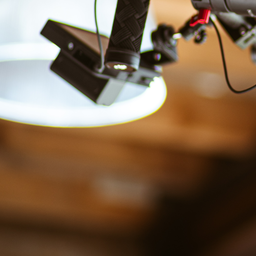
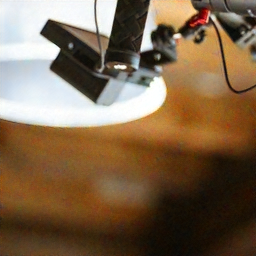
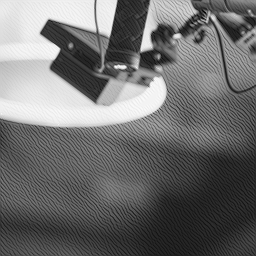
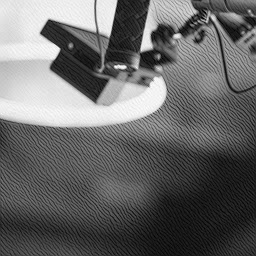


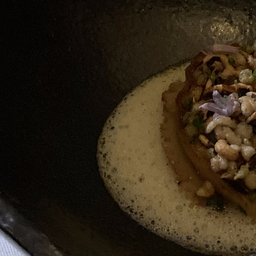
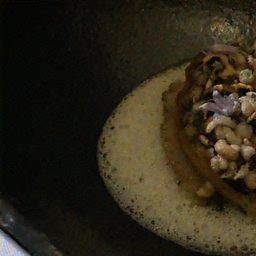
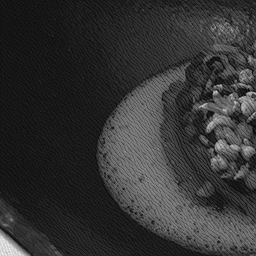
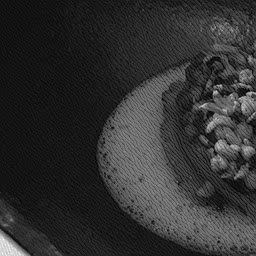


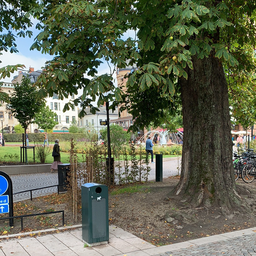
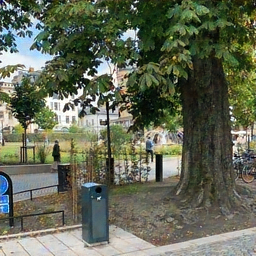
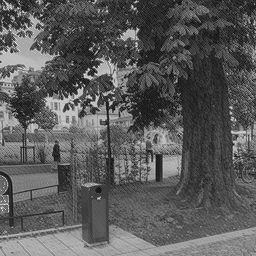
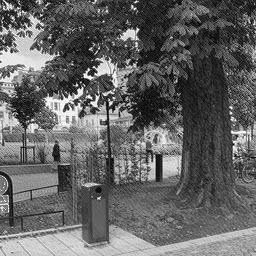


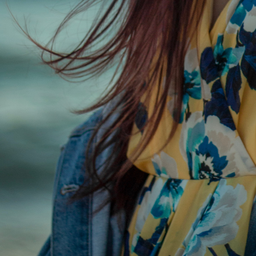
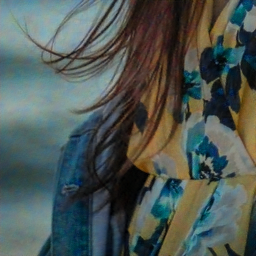
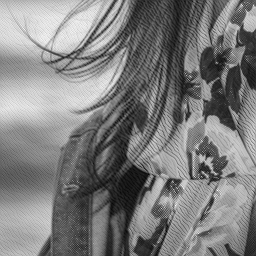
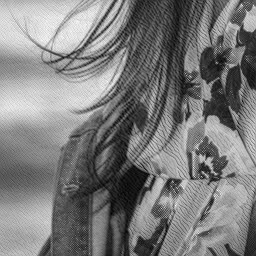


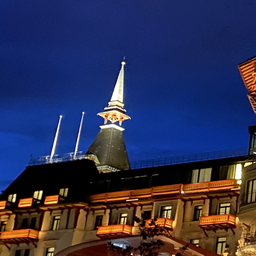
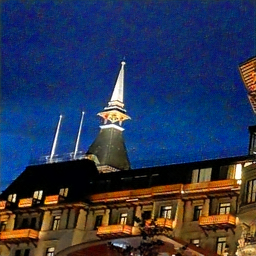
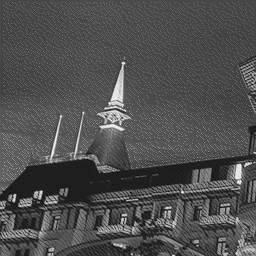
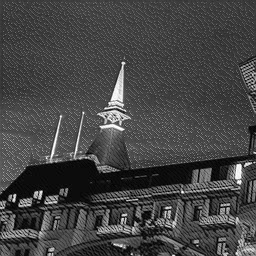


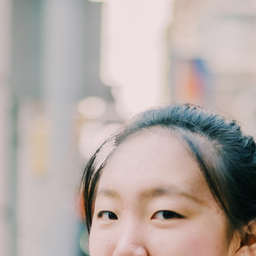
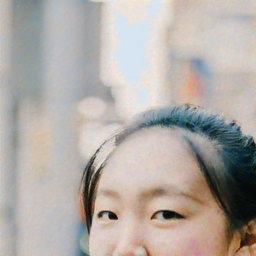
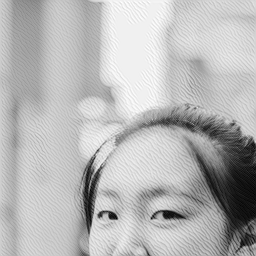
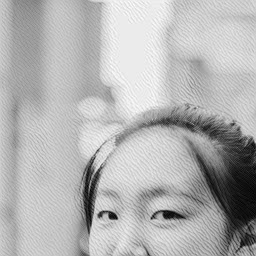


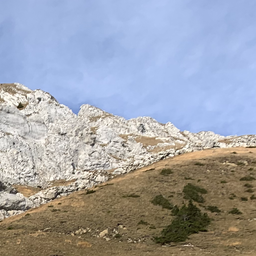
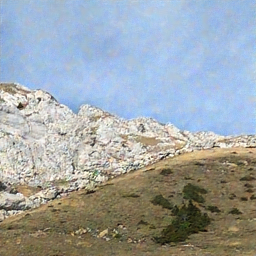
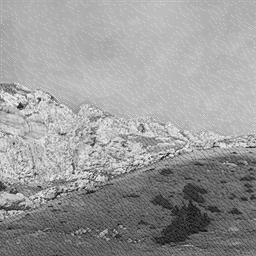
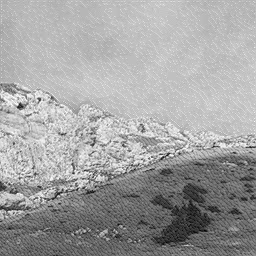


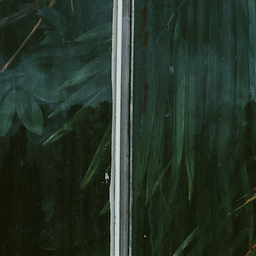
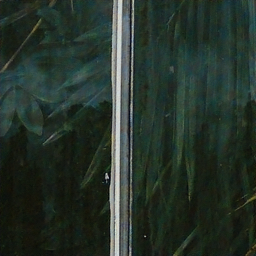
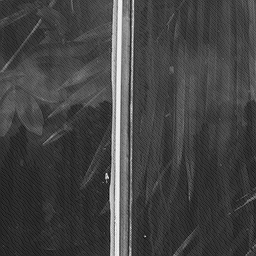
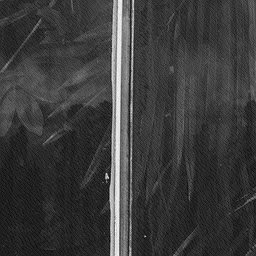


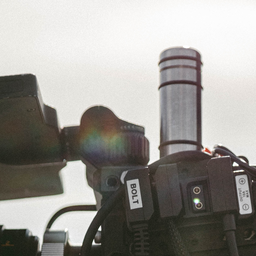
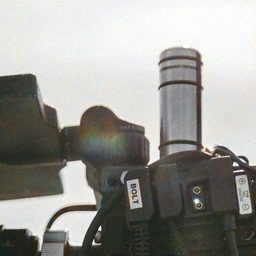
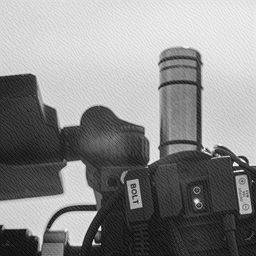
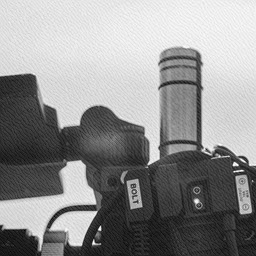


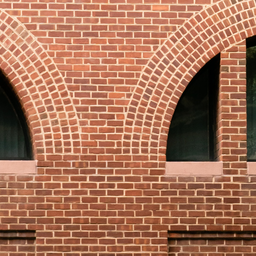
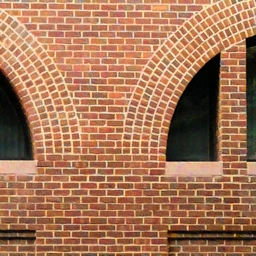
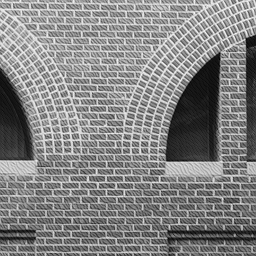
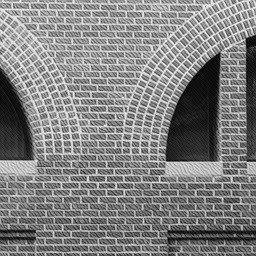

In [ ]:
# It is recommended to generate R-D curves by training multiple models for
# multiple gammas, then evaluate each model for multiple qsteps, and construct
# the Pareto frontier. Please see the paper for details:
# https://arxiv.org/abs/2402.05887

# Pictures to show. Can also look at the proxy rate through 'rate', calcaulate
# distortion or whatever else you would like.
show_keys = ['prediction', 'bottleneck', 'compressed_bottleneck']
show_count = 10

for idx, sample in enumerate(eval_dataset.as_numpy_iterator()):
  if idx >= show_count:
    break

  # Path 1: Simple demo:
  # Run the pre-processor, codec-proxy, and the post-procesor.
  output = base_model(sample)

  # Path 2: Actual performance with your codec:
  # Run the pre-processor, your codec, then post-processor.
  #
  # bottlenecks = base_model.run_preprocessor(sample, training=False)
  # compressed_bottlenecks = insert_your_image_codec_binary(bottlenecks)
  # output = {
  #     'bottleneck': bottlenecks,
  #     'compressed_bottleneck': compressed_bottlenecks,
  #     'prediction': base_model.run_postprocessor(
  #         compressed_bottlenecks, training=False
  #     ),
  # }

  images = {'original': sample['image'][0] / 255}
  images.update(
      {key: value[0] / 255 for key, value in output.items() if key in show_keys}
  )
  media.show_images(images, height=256)